In [1]:
from __future__ import absolute_import
from matplotlib import pyplot as plt
import numpy as np
from preprocess import get_data

In [2]:
import gzip
import numpy as np

In [3]:
def get_data(inputs_file_path, labels_file_path, num_examples):
    """
    Takes in an inputs file path and labels file path, unzips both files, 
    normalizes the inputs, and returns (NumPy array of inputs, NumPy array of labels). 
    
    Read the data of the file into a buffer and use 
    np.frombuffer to turn the data into a NumPy array. Keep in mind that 
    each file has a header of a certain size. This method should be called
    within the main function of the model.py file to get BOTH the train and
    test data. 
    
    If you change this method and/or write up separate methods for 
    both train and test data, we will deduct points.
    
    :param inputs_file_path: file path for inputs, e.g. 'MNIST_data/t10k-images-idx3-ubyte.gz'
    :param labels_file_path: file path for labels, e.g. 'MNIST_data/t10k-labels-idx1-ubyte.gz'
    :param num_examples: used to read from the bytestream into a buffer. Rather 
    than hardcoding a number to read from the bytestream, keep in mind that each image
    (example) is 28 * 28, with a header of a certain number.
    :return: NumPy array of inputs (float32) and labels (uint8)
    """
          
    # TODO: Load inputs and labels
    with gzip.GzipFile(filename = inputs_file_path) as b_inputs:
        buffer = b_inputs.read(16) # ignore first 16 bits 
        inputs = np.frombuffer(b_inputs.read(num_examples * 28 * 28), dtype=np.uint8)
        # inputs here is a huge row vector 
        inputs = inputs.reshape((num_examples, 28 * 28)) # reshape inputs to shape (num_examples, 28*28)
         
    
    with gzip.GzipFile(filename = labels_file_path) as b_labels:
        buffer = b_labels.read(8) # ignore first 8 bits 
        outputs = np.frombuffer(b_labels.read(num_examples), dtype=np.uint8)



    # TODO: Normalize inputs
    inputs = inputs / 255.
    inputs = inputs.astype(np.float32)
    
    
    return inputs, outputs

In [4]:
a, b = get_data("/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/train-images-idx3-ubyte.gz", 
                "/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/train-labels-idx1-ubyte.gz",
                 10)
b[0]

5

In [5]:
class Model:
    """
    This model class will contain the architecture for
    your single layer Neural Network for classifying MNIST with 
    batched learning. Please implement the TODOs for the entire 
    model but do not change the method and constructor arguments. 
    Make sure that your Model class works with multiple batch 
    sizes. Additionally, please exclusively use NumPy and 
    Python built-in functions for your implementation.
    """

    def __init__(self):
        # TODO: Initialize all hyperparametrs
        self.input_size = 784 # Size of image vectors
        self.num_classes = 10 # Number of classes/possible labels
        self.batch_size = 100
        self.learning_rate = 0.5

        # TODO: Initialize weights and biases
        self.W = np.zeros((self.input_size, self.num_classes)) # size 784*10
        self.b = np.zeros((1, self.num_classes)) # size 1 * 10
    
    def call(self, inputs):
        """
        Does the forward pass on an batch of input images.
        
        :param inputs: normalized (0.0 to 1.0) batch of images,
                       (batch_size x 784) (2D), where batch can be any number.
        :return: probabilities for each class per image # (batch_size x 10)
        """
        # TODO: Write the forward pass logic for your model
        # TODO: Calculate, then return, the probability for each class per image using the Softmax equation

        linear_layer = np.dot(inputs, self.W) + self.b # (100, 784) * (784, 10) + (1, 10); add bias to each row
                                                       # final answer: (100,10)
        
        e_logit = np.exp(linear_layer) # numerator of softmax function # (100,10)
        sum_e_logit = np.sum(e_logit, axis = 1, keepdims = True) # row sum; (1, 10)
        probabilities = e_logit / sum_e_logit  # the final answer is a matrix (100,10)
        # each input in the e_logit(which is wi * xi + bi) is divided by the row sum 
        # the calculation is between matrix (100, 10) and matrix (1, 10)
        return probabilities # softmax probability (100, 10)
    
    def loss(self, probabilities, labels): 
        """
        Calculates the model cross-entropy loss after one forward pass.
        Loss should be decreasing with every training loop (step). 
        NOTE: This function is not actually used for gradient descent 
        in this assignment, but is a sanity check to make sure model 
        is learning.

        :param probabilities: matrix that contains the probabilities 
        of each class for each image
        :param labels: the true batch labels
        :return: average loss per batch element (float)
        """
        # TODO: Calculate average cross-entropy loss for a batch
        

        # l = np.eye(10)[labels] # like one-hot encoding 
        
        
        # labels: array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)
        # labels[0] = 5
        
        l = np.zeros((labels.shape[0], self.num_classes)) # dimension (100, 10)

        for i in range(labels.shape[0]):
            l[i, labels[i]] = 1 
        
        
        entropy_loss = np.multiply(-np.log(probabilities), l)
        final = np.sum(entropy_loss)
        return final

        '''
        loss = -np.log(probabilities[range(self.batch_size), labels]) 
        # probabilities[range(self.batch_size), labels] returns a row vector contains the probability of that label
        # of 100 batch samples;  (1, 100)
        entropy_loss = np.sum(loss) / self.batch_size 
        # sum across all 100 losses and take average 
        
        return entropy_loss 
        '''
        
    def back_propagation(self, inputs, probabilities, labels):
        """
        Returns the gradients for model's weights and biases 
        after one forward pass and loss calculation. The learning 
        algorithm for updating weights and biases mentioned in 
        class works for one image, but because we are looking at 
        batch_size number of images at each step, you should take the
        average of the gradients across all images in the batch.

        :param inputs: batch inputs (a batch of images)
        :param probabilities: matrix that contains the probabilities of each 
        class for each image
        :param labels: true labels
        :return: gradient for weights, and gradient for biases
        """
        # TODO: Calculate the gradients for the weights and the gradients for the bias with respect to average loss
    
        
        # Y = np.eye(self.batch_size)[labels, 0:self.num_classes]  # like one-hot encoding
        #print(f'Y.shape is: {Y.shape}') # dimension: (100,10)
        
        
        Y = np.zeros((labels.shape[0], self.num_classes)) # labels.shape[0] = 100; dimension (100, 10)
        for i in range(labels.shape[0]):
            Y[i, labels[i]] = 1 

            
        gradW =  self.learning_rate * np.dot(np.transpose(inputs), (probabilities - Y)) / self.batch_size  # gradient formula for weight
        # np.transepose(inputs): dimension changes to (784, 100)
        # (probabilities - Y): (100, 10)
        # final result is (784, 10): the gradient for every weight in the weight matrix 
        gradB =  self.learning_rate * np.sum((probabilities - Y), axis = 0) / self.batch_size # gradient formula for bias 
        # (probabilities - Y): (100, 10)
        # final answer: (1, 10)
        # the reason we sum across the column is becuase we add every effect for that label together and take average for that label
        
        return gradW, gradB
    
    def accuracy(self, probabilities, labels):
        """
        Calculates the model's accuracy by comparing the number 
        of correct predictions with the correct answers.
        
        :param probabilities: result of running model.call() on test inputs
        :param labels: test set labels
        :return: batch accuracy (float [0,1])
        """
        # TODO: Calculate the batch accuracy
        
        output = np.argmax(probabilities, axis = 1) 
        # return a row vector containing the index of the biggest number of each row 
        total_true = sum(output == labels)
        
        score = total_true / labels.shape[0] # calculate the accuracy score 
        
        return score

    def gradient_descent(self, gradW, gradB):
        '''
        Given the gradients for weights and biases, does gradient 
        descent on the Model's parameters.
        
        :param gradW: gradient for weights
        :param gradB: gradient for biases
        :return: None
        '''
        # TODO:= Change the weights and biases of the model to descend the gradient
        self.W -= gradW  
        self.b -= gradB
        
    

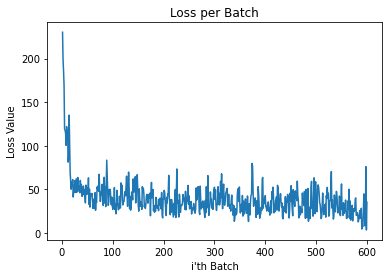

0.9053


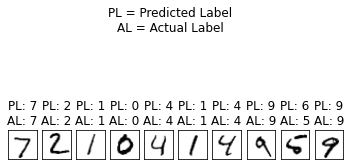

In [6]:
  
def train(model, train_inputs, train_labels):
    '''
    Trains the model on all of the inputs and labels.
    :param model: the initialized model to use for the forward 
    pass and backward pass
    
    :param train_inputs: train inputs (all inputs to use for training)
    :param train_inputs: train labels (all labels to use for training)
    :return: None
    '''
    # TODO: Iterate over the training inputs and labels, in model.batch_size increments and do forward pass
    # TODO: For every batch, compute and then descend the gradients for the model's weights
    # Optional TODO: Call visualize_loss and observe the loss per batch as the model trains
    
    number = train_inputs.shape[0] // model.batch_size # number of iteration to go over 
    l = [] # initiate loss array 
    for i in range(number):
        inputs = train_inputs[model.batch_size * i : model.batch_size * (i+1), :]  # create input batch from train_inputs
        labels = train_labels[model.batch_size * i : model.batch_size * (i+1)] # create labels batch from train_labels
        probabilities = model.call(inputs) # calculate soft max probabilities
        l.append(model.loss(probabilities, labels)) # calculate loss function 
        gradW, gradB = model.back_propagation(inputs, probabilities, labels) # get gradient values 
        model.gradient_descent(gradW, gradB)
    visualize_loss(l)
    


def test(model, test_inputs, test_labels):
    """
    Tests the model on the test inputs and labels. For this assignment, 
    the inputs should be the entire test set, but in the future we will
    ask you to batch it instead.
    
    :param test_inputs: MNIST test data (all images to be tested)
    :param test_labels: MNIST test labels (all corresponding labels)
    :return: accuracy (float [0,1])
    """
    # TODO: Iterate over the testing inputs and labels
    # TODO: Return accuracy across testing set
    probabilities = model.call(test_inputs)
    score = model.accuracy(probabilities, test_labels) # using accuracy function defined above to calculate accuracy for test inputs and labels
    return score 
    

def visualize_loss(losses):
    """
    NOTE: DO NOT EDIT

    Uses Matplotlib to visualize loss per batch. Call this in train().
    When you observe the plot that's displayed, think about:
    1. What does the plot demonstrate or show?
    2. How long does your model need to train to reach roughly its best accuracy so far, 
    and how do you know that?
    Optionally, add your answers to README!
    
    :param losses: an array of loss value from each batch of train
    :return: does not return anything, a plot should pop-up
    """
    x = np.arange(1, len(losses)+1)
    plt.xlabel('i\'th Batch')
    plt.ylabel('Loss Value')
    plt.title('Loss per Batch')
    plt.plot(x, losses)
    plt.show()

    
def visualize_results(image_inputs, probabilities, image_labels):
    """
    NOTE: DO NOT EDIT

    Uses Matplotlib to visualize the results of our model.
    
    :param image_inputs: image data from get_data()
    :param probabilities: the output of model.call()
    :param image_labels: the labels from get_data()
    :return: does not return anything, a plot should pop-up 
    """
    images = np.reshape(image_inputs, (-1, 28, 28))
    predicted_labels = np.argmax(probabilities, axis=1)
    num_images = images.shape[0]

    fig, axs = plt.subplots(ncols=num_images)
    fig.suptitle("PL = Predicted Label\nAL = Actual Label")
    for ind, ax in enumerate(axs):
        ax.imshow(images[ind], cmap="Greys")
        ax.set(title="PL: {}\nAL: {}".format(predicted_labels[ind], image_labels[ind]))
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
    plt.show()

def main():
    '''
    Read in MNIST data, initialize your model, and train and test your model 
    for one epoch. The number of training steps should be your the number of 
    batches you run through in a single epoch. You should receive a final accuracy on the testing examples of > 80%.
    
    :return: None
    '''

    # TODO: load MNIST train and test examples into train_inputs, train_labels, test_inputs, test_labels
    train_inputs, train_labels = get_data('/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/train-images-idx3-ubyte.gz', '/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/train-labels-idx1-ubyte.gz', 60000)
    test_inputs, test_labels = get_data('/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/t10k-images-idx3-ubyte.gz', '/Users/justinli/Desktop/CSCI2470/homework1/hw1/code/data/t10k-labels-idx1-ubyte.gz', 10000)
    
    # TODO: Create Model
    model = Model() # initiate model as class Model 
    
    # TODO: Train model by calling train() ONCE on all data
    train(model, train_inputs, train_labels)

    # TODO: Test the accuracy by calling test() after running train()
    accuracy = test(model, test_inputs, test_labels)
    print(accuracy)
    
    # TODO: Visualize the data by using visualize_results()
    image_inputs = test_inputs[0:10, :] # visualize the first 10 test images 
    probabilities = model.call(image_inputs)
    image_labels = test_labels[0:10]
    visualize_results(image_inputs, probabilities, image_labels)

    
if __name__ == '__main__':
    main()

In [7]:
x = np.array([[1,2],[3,4]])
y = np.array([[5,6],[7,8]])
c = np.array([[1],[2]])

In [8]:
print(x)
b = np.sum(x, axis = 1)
print(b)
np.expand_dims(b,axis = 1) 

[[1 2]
 [3 4]]
[3 7]


array([[3],
       [7]])

In [9]:
print(x)
print(c)
x / c

[[1 2]
 [3 4]]
[[1]
 [2]]


array([[1. , 2. ],
       [1.5, 2. ]])

In [10]:
a = np.array([[1,2,3,4,5],[6,7,8,9,10]])
a

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [11]:
a[range(2),3]

array([4, 9])

In [12]:
np.log(a[range(2),3])

array([1.38629436, 2.19722458])

In [13]:
a = np.array([[1,2,3], [4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [14]:
b = np.transpose(a)
print(b)
np.argmax(b, axis = 1)

[[1 4]
 [2 5]
 [3 6]]


array([1, 1, 1])

In [15]:
a = np.array([[1,3],[2,4],[3,5]])
print(a)
a[2,0]


[[1 3]
 [2 4]
 [3 5]]


3

In [16]:
l = np.zeros((3,4))
l.shape[0]
print(l)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [17]:
l[0][0]

0.0

In [22]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
print(np.sum(a, axis = 1))
print(np.sum(a, axis = 1, keepdims = True)) # keep the final answer as a column vector 

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[ 6 15 24]
[[ 6]
 [15]
 [24]]
